## FINGER TAPPING ANALYSIS
##### Data collected from patients with neurodegenerative disorders as well as healthy controls

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import time
import sys
from tqdm import tqdm
import os
import pandas as pd
import seaborn as sns
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import math
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Model, load_model
from keras.layers import Input, Conv1D, Flatten, Dropout, MaxPooling1D, Dense
from keras.layers import Activation, BatchNormalization, concatenate
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
%matplotlib inline

C:\Users\Korisnik\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [24]:
# Read the data
path = 'C:/Users/Korisnik/Desktop/Minjino/TAPPING/'
# test = scipy.io.loadmat(path + 'TestDataSingleCrop.mat')

#test = scipy.io.loadmat(path + 'TestDataSingleCrop.mat')
test = scipy.io.loadmat(path + 'ValData.mat')
Xtest, Ytest = test['X'], test['Y']

In [25]:
Xtest.shape, Ytest.shape

((432, 1800, 6), (432, 4))

### Model load

In [4]:
model = load_model(path + 'MODELCNN16Batch9s9KERNEL9CEO.h5')
model.load_weights(path+'!BEST_WEIGHTSCNN16Batch9s9KERNEL9.10.10.2018.9.20.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1800, 6)           0         
_________________________________________________________________
Conv1x500 (Conv1D)           (None, 1800, 32)          1760      
_________________________________________________________________
ReLu00 (Activation)          (None, 1800, 32)          0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 1800, 32)          128       
_________________________________________________________________
Conv1x501 (Conv1D)           (None, 1800, 32)          9248      
_________________________________________________________________
ReLu01 (Activation)          (None, 1800, 32)          0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 1800, 32)          128       
__________

In [5]:
def predictSignal(signalX, signalY, model, verbose = 1):
    signalX = np.expand_dims(signalX,axis=0)
    prediction = model.predict(signalX)
    prediction = prediction[0]
    prediction = np.round(np.float64(prediction),2)
    
    d = {0: 'CTRL',
        1: 'MSA',
        2: 'PD',
        3: 'PSP'}
    
    

    actualDiagnosis = d[np.argmax(signalY)]
    predictedDiagnosis = d[np.argmax(prediction)]
    
    if verbose:
        print('predictedDiagnosis: ',predictedDiagnosis)
        print('actualDiagnosis: ', actualDiagnosis)
        print('Certainty: \nCTRL: {} \nMSA: {} \nPD: {} \nPSP: {}'.format(prediction[0],
                                                                      prediction[1],
                                                                      prediction[2],
                                                                      prediction[3]))
        print('#################################################')
   
    
    return {"Predicted": predictedDiagnosis, "Actual": actualDiagnosis}

In [21]:
def confuseMat(Xtest, Ytest,model):
    p, a = [], []
    for X,Y in zip(Xtest,Ytest):
        temp = predictSignal(X,Y,model,verbose=0)
        p.append(temp['Predicted'])
        a.append(temp['Actual'])
    confMat = confusion_matrix(p,a)
    print(confMat)
    confMatPerc = confMat.astype('float')/confMat.sum(axis=1)
    return [confMat,confMatPerc]
    

In [22]:
def plotConfMat(cm,cmPerc):
    plt.figure(figsize = (10,10))
    plt.imshow(cmPerc)
    plt.colorbar()
    for i,j in itertools.product(range(4),range(4)):
        plt.text(i,j,format(cm[j,i],'d'),
                horizontalalignment = "center",
                color = "white" if cmPerc[j,i]<0.6 else "black",
                size = 15)
    tick_marks = np.arange(4)
    classes = ['CTRL','MSA','PD','PSP']
    plt.xticks(tick_marks,classes,rotation = 45,size = 15)
    plt.yticks(tick_marks,classes,size = 15)
    plt.ylabel('True label',size = 15)
    plt.xlabel('\nPredicted label',size = 15)
    plt.style.use(['tableau-colorblind10'])
    plt.title('Confusion matrix\n', size = 17)
    plt.show()
    return

[[ 75   0   0   1]
 [  1 100   0   1]
 [  8   1 106   0]
 [  0  11   0 128]]


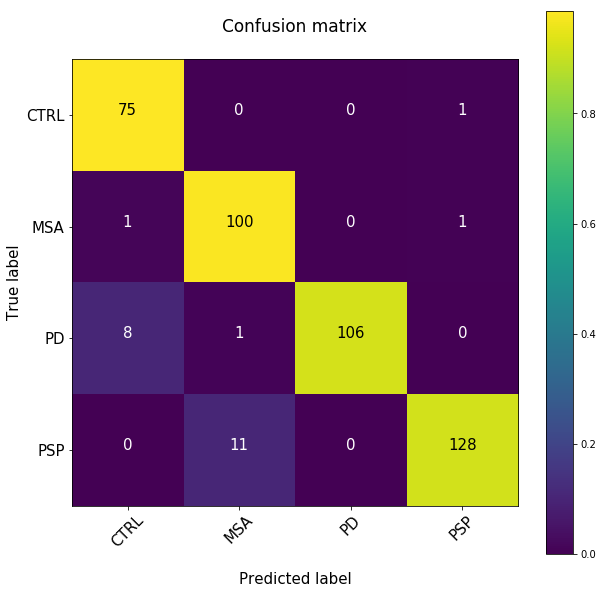

In [26]:
cm, cmPerc = confuseMat(Xtest,Ytest,model)
plotConfMat(cm,cmPerc)

In [9]:
# samples = [1,2,20,50,54,55,84,95,102,111]

In [10]:
# get the diagnosis
# for i in samples:
#     e = predictSignal(Xtest[i],Ytest[i],model,verbose=0)